# Grupo 9 

## Integrantes:


# Bibliotecas y Módulos en uso

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify as sq
from sklearn import set_config
import shap
import lime
#import dtale as dl


#Transformers & Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline, make_union, FeatureUnion
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTENC, RandomOverSampler

#Metrics
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score,classification_report,confusion_matrix,precision_recall_curve,auc,precision_score,recall_score, plot_roc_curve
from sklearn.metrics import fbeta_score, PrecisionRecallDisplay, make_scorer


#Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier


#Feature Importances
from sklearn.feature_selection import SelectKBest, f_classif,RFECV,RFE

%matplotlib inline
set_config(display="diagram") #assume_finite
from tempfile import mkdtemp
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


# Definicion de Funciones

In [2]:
#Funcion para mostrar etiquetas de valores en parte superior del la barra en los graficos de barras
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.3f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
#Funcion custom score para establecer score propio para GridSearch
def custom_score(y_true,y_pred):
    return fbeta_score(y_true,y_pred,beta = 1, average='weighted')


# Instalacion de Modulos

In [3]:
#!pip install squarify
#pip install shap

# Presentacion del Caso

Se trabajara sobre un dataset de 110.527 registros de citas medicas teniendo 14 variables o caracteristicas (features) de cada observacion.

(link: https://www.kaggle.com/ksevenk/medical-appointments-no-show-case-study)

## Objetivos

- Realizar analisis exploratorio de los datos para lograr un mejor entendimiento del caso.
- Limpieza de los datos.
- Establecer un baseline y score sobre el cual va a trabajar el estimador.
- Confeccionar clasficador que prediga el target 'No-Show'.
- Conclusiones.

## Descripción de Columnas

- Gender : Sexo
- ScheduledDay : Dia en que se agenda el turno
- AppointmentDay : Dia del turno
- Age : Edad
- Neighbourhood :Barrio
- Scholarship : Si tiene bolsa familia
- Hipertension : Si el paciente tiene hipertencion
- Diabetes : Si el paciente tiene diabetes
- Alcoholism : Si el paciente tiene alcolismo
- Handcap : Cantidad de discapacidades que tiene el paciente
- SMS_received : Si se le ha enviado un sms de recordatorio
- No-show : Si el paciente ha faltado

In [4]:
path = 'KaggleV2-May-2016.csv'

data_raw = pd.read_csv(path)
data_raw.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


# Analisis Exploratorio de Datos 

## Valores unicos por columna

In [5]:
pd.DataFrame({'Cantidad de valores unicos':data_raw.agg(lambda x: len(pd.unique(x))), 
              'Valores unicos':data_raw.agg(lambda x: (pd.unique(x)))
             })

,Cantidad de valores unicos,Valores unicos
PatientId,62299,"[29872499824296.0, 558997776694438.0, 42629622..."
AppointmentID,110527,"[5642903, 5642503, 5642549, 5642828, 5642494, ..."
Gender,2,"[F, M]"
ScheduledDay,103549,"[2016-04-29T18:38:08Z, 2016-04-29T16:08:27Z, 2..."
AppointmentDay,27,"[2016-04-29T00:00:00Z, 2016-05-03T00:00:00Z, 2..."
Age,104,"[62, 56, 8, 76, 23, 39, 21, 19, 30, 29, 22, 28..."
Neighbourhood,81,"[JARDIM DA PENHA, MATA DA PRAIA, PONTAL DE CAM..."
Scholarship,2,"[0, 1]"
Hipertension,2,"[1, 0]"
Diabetes,2,"[0, 1]"


In [6]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [7]:
data_raw.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


Observamos que el dataset no posee valores nulos aunque se observan los siguientes aspectos:
- El minimo de edad es -1.
- Hay 62.299 PatientId y 110.527 citas por lo que se deduce que existe mas de un registro por paciente. 
- Los datos del tipo fecha no se encuentran 'formateados' correctamente y se pueden extraer de aque otras features. 
- La feature 'Neighbourhood' no la encontramos relevante para este analisis ya que desconocemos datos referidos a la localizacion del hospital y se opta por descartarla.


## Conversión de datos

In [8]:
#Se convierten datos a tipo date
data_raw['ScheduledDay_time'] = pd.to_datetime(data_raw.ScheduledDay)
data_raw['AppointmentDay_time'] = pd.to_datetime(data_raw.AppointmentDay)
data_raw['PatientId'] = data_raw['PatientId'].astype('int')

#Se extraen atributos de fechas
#Scheduled
data_raw['ScheduledDay_day_of_week'] = data_raw['ScheduledDay_time'].transform(lambda x: x.day_name(), axis = 0)
data_raw['ScheduledDay_day'] = data_raw['ScheduledDay_time'].transform(lambda x: x.dt.day, axis = 0)
data_raw['ScheduledDay_month'] = data_raw['ScheduledDay_time'].transform(lambda x: x.dt.month, axis = 0)
data_raw['ScheduledDay_year'] = data_raw['ScheduledDay_time'].transform(lambda x: x.dt.year, axis = 0)
#Appointment
data_raw['AppointmentDay_day_of_week'] = data_raw['AppointmentDay_time'].transform(lambda x: x.day_name(), axis = 0)
data_raw['AppointmentDay_day'] = data_raw['AppointmentDay_time'].transform(lambda x: x.dt.day, axis = 0)
data_raw['AppointmentDay_month'] = data_raw['AppointmentDay_time'].transform(lambda x: x.dt.month, axis = 0)
data_raw['AppointmentDay_year'] = data_raw['AppointmentDay_time'].transform(lambda x: x.dt.year, axis = 0)

#Se crea feature days between dates = dbd que es el tiempo que transcurre entre que la persona agenda el turno y el momento en que se da el turno
data_raw['dbd'] = (data_raw['AppointmentDay_time'].dt.date - data_raw['ScheduledDay_time'].dt.date).dt.days

#Se mapea target con valores numericos
data_raw['No_show'] = data_raw['No-show'].map({'Yes': 1, 'No': 0})

#Se crea feature para procesamiento
data_raw['aux'] = 1

# Limpieza de datos

- Se eliminan las columnas que no van a hacer necesarias:
    - ['ScheduledDay', 'AppointmentDay', 'No-show', 'AppointmentID']
- Se eliminan valores de edad 'negativos'.
- Se eliminan observaciones con dbd negativo.
- Se buscaran valores duplicados y se eliminaran


In [9]:
data = data_raw.drop(columns = ['ScheduledDay', 'AppointmentDay', 'No-show', 'AppointmentID'])

In [10]:
age_mask = (data.Age < 0)
age_mask.sum()

1

In [11]:
data[age_mask]

,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,...,ScheduledDay_day,ScheduledDay_month,ScheduledDay_year,AppointmentDay_day_of_week,AppointmentDay_day,AppointmentDay_month,AppointmentDay_year,dbd,No_show,aux
99832,465943158731293,F,-1,ROMÃO,0,0,0,0,0,0,...,6,6,2016,Monday,6,6,2016,0,0,1


In [12]:
data = data.drop(index = data[(data.Age < 0)].index)

In [13]:
dbd_mask = (data.dbd < 0)
dbd_mask.sum()

5

In [14]:
data[dbd_mask]

,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,...,ScheduledDay_day,ScheduledDay_month,ScheduledDay_year,AppointmentDay_day_of_week,AppointmentDay_day,AppointmentDay_month,AppointmentDay_year,dbd,No_show,aux
27033,7839272661752,M,38,RESISTÊNCIA,0,0,0,0,1,0,...,10,5,2016,Monday,9,5,2016,-1,1,1
55226,7896293967868,F,19,SANTO ANTÔNIO,0,0,0,0,1,0,...,18,5,2016,Tuesday,17,5,2016,-1,1,1
64175,24252258389979,F,22,CONSOLAÇÃO,0,0,0,0,0,0,...,5,5,2016,Wednesday,4,5,2016,-1,1,1
71533,998231581612122,F,81,SANTO ANTÔNIO,0,0,0,0,0,0,...,11,5,2016,Thursday,5,5,2016,-6,1,1
72362,3787481966821,M,7,TABUAZEIRO,0,0,0,0,0,0,...,4,5,2016,Tuesday,3,5,2016,-1,1,1


In [15]:
data = data.drop(index = data[dbd_mask].index)

In [16]:
data.duplicated().sum()

618

In [17]:
data.drop_duplicates(inplace=True)

# Analisis de Variables

## Balance del Target

In [18]:
data['No_show'].value_counts(normalize = True)

0    0.798914
1    0.201086
Name: No_show, dtype: float64

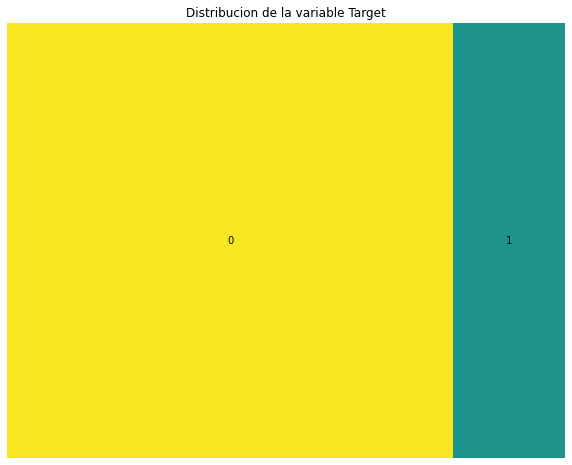

In [19]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes()
sq.plot(sizes=data.No_show.value_counts().values, label=data.No_show.value_counts(normalize = True).index, alpha=1, ax = ax)
plt.axis('off')
plt.title('Distribucion de la variable Target')
plt.show()

Se observa un dataset desbalanceado con respecto a la variable target.

## Analisis por Edad

<AxesSubplot:xlabel='Density', ylabel='Age'>

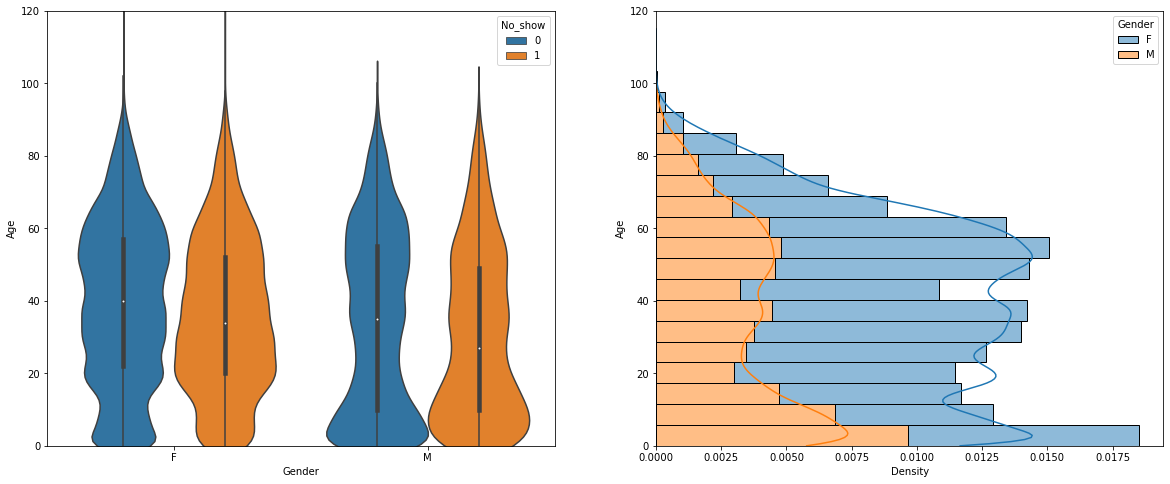

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False)
fig.set_figwidth(20)
fig.set_figheight(8)
axes[0].set_ylim([0, 120])
axes[1].set_ylim([0, 120])

sns.violinplot(x=data["Gender"], y=data["Age"], hue = data['No_show'], ax = axes[0])
sns.histplot(data=data, y="Age", hue ="Gender", kde=True, multiple="stack", stat ='density', bins = 20, ax= axes[1])


<AxesSubplot:xlabel='Age'>

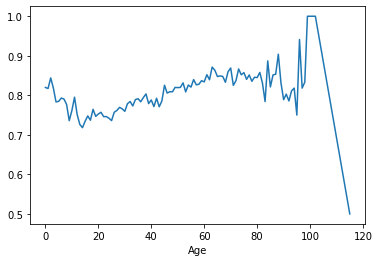

In [21]:
data.groupby("Age")['No_show'].value_counts(normalize = True).loc[:,0].plot()

### Se filtran outliers de Edad

<AxesSubplot:title={'center':'Asistencia por Edad'}, xlabel='Age'>

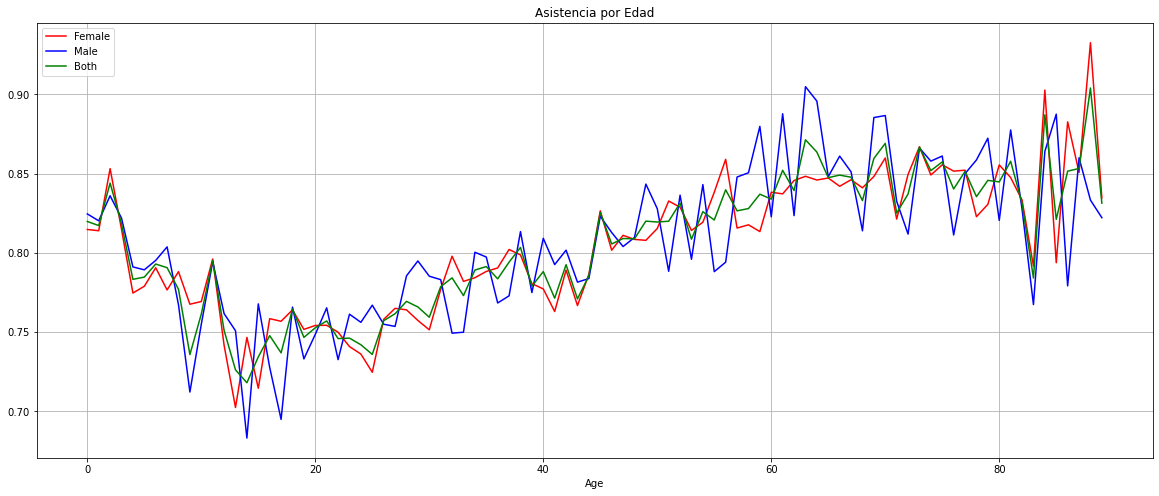

In [22]:
data[data.Age < 90].groupby(['Age','Gender'])['No_show'].value_counts(normalize=True).loc[:,'F'].loc[:,0].plot(color='red', label = 'Female', legend = True)
data[data.Age < 90].groupby(['Age','Gender'])['No_show'].value_counts(normalize=True).loc[:,'M'].loc[:,0].plot(color='blue', label = 'Male', legend = True)
data[data.Age < 90].groupby("Age")['No_show'].value_counts(normalize = True).loc[:,0].plot(figsize=(20,8), title = 'Asistencia por Edad', grid = True, color='green', label = 'Both', legend = True)


## Analisis de Alcoholismo

In [23]:
alc_df = pd.DataFrame(data.groupby(['Alcoholism', 'Gender'], as_index= True)['No_show'].value_counts(normalize = True)).rename(columns={"No_show": "Prob_asistencia"}).reset_index()
alc = alc_df[alc_df.No_show == 0].drop(columns = 'No_show')
alc

,Alcoholism,Gender,Prob_asistencia
0,0,F,0.798413
2,0,M,0.799758
4,1,F,0.751027
6,1,M,0.828397


<AxesSubplot:xlabel='Alcoholism', ylabel='Prob_asistencia'>

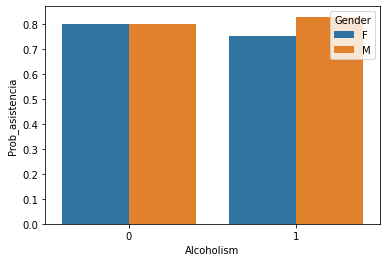

In [24]:
sns.barplot(data = alc, hue = 'Gender', x ='Alcoholism', y = 'Prob_asistencia')

## Analisis de Diabetes

In [25]:
dia_df = pd.DataFrame(data.groupby(['Diabetes', 'Gender'], as_index= True)['No_show'].value_counts(normalize = True)).rename(columns={"No_show": "Prob_asistencia"}).reset_index()
dia = dia_df[dia_df.No_show == 0].drop(columns = 'No_show')
dia

,Diabetes,Gender,Prob_asistencia
0,0,F,0.795848
2,0,M,0.799928
4,1,F,0.818361
6,1,M,0.823402


<AxesSubplot:xlabel='Diabetes', ylabel='Prob_asistencia'>

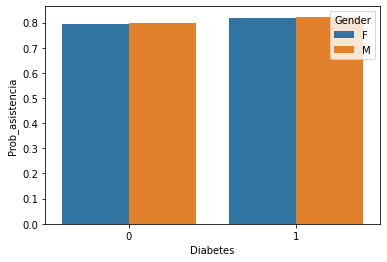

In [26]:
sns.barplot(data = dia, hue = 'Gender', x ='Diabetes', y = 'Prob_asistencia')

## Analisis de Hipertension

In [27]:
hip_df = pd.DataFrame(data.groupby(['Hipertension', 'Gender'], as_index= True)['No_show'].value_counts(normalize = True)).rename(columns={"No_show": "Prob_asistencia"}).reset_index()
hip = hip_df[hip_df.No_show == 0].drop(columns = 'No_show')
hip

,Hipertension,Gender,Prob_asistencia
0,0,F,0.789494
2,0,M,0.795790
4,1,F,0.827457
6,1,M,0.829074


<AxesSubplot:xlabel='Hipertension', ylabel='Prob_asistencia'>

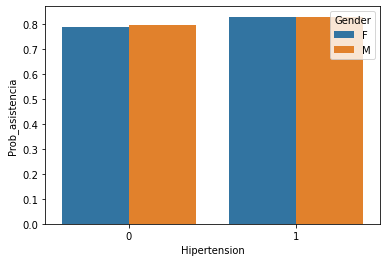

In [28]:
sns.barplot(data = hip, hue = 'Gender', x ='Hipertension', y = 'Prob_asistencia')

## Analisis de Bolsa Familia

In [29]:
sco_df = pd.DataFrame(data.groupby(['Scholarship', 'Gender'], as_index= True)['No_show'].value_counts(normalize = True)).rename(columns={"No_show": "Prob_asistencia"}).reset_index()
sco = sco_df[sco_df.No_show == 0].drop(columns = 'No_show')
sco

,Scholarship,Gender,Prob_asistencia
0,0,F,0.802549
2,0,M,0.803223
4,1,F,0.762462
6,1,M,0.766917


<AxesSubplot:xlabel='Scholarship', ylabel='Prob_asistencia'>

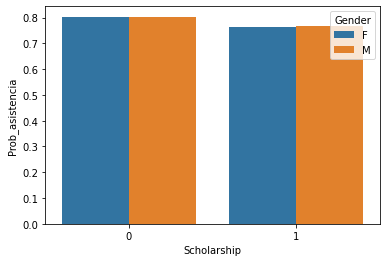

In [30]:
sns.barplot(data = sco, hue = 'Gender', x ='Scholarship', y = 'Prob_asistencia')

## Analisis de SMS_received

In [264]:
data['SMS_received'] = data_raw['SMS_received']#.map({0 : 1, 1 : 0})


In [265]:
sms_df = pd.DataFrame(data.groupby(['SMS_received', 'Gender'], as_index= True)['No_show'].value_counts(normalize = True)).rename(columns={"No_show": "Prob_asistencia"}).reset_index()
sms = sms_df[sms_df.No_show == 0].drop(columns = 'No_show')
sms

,SMS_received,Gender,Prob_asistencia
0,0,F,0.836348
2,0,M,0.831534
4,1,F,0.722218
6,1,M,0.728169


<AxesSubplot:xlabel='SMS_received', ylabel='Prob_asistencia'>

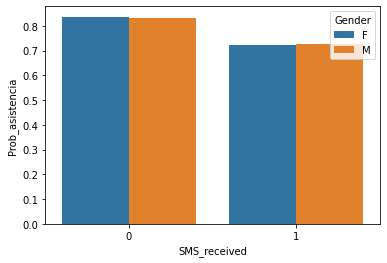

In [266]:
sns.barplot(data = sms, hue = 'Gender', x ='SMS_received', y = 'Prob_asistencia')

## Analisis de Discapacidades

In [34]:
dis_df = pd.DataFrame(data.groupby(['Handcap', 'Gender'], as_index= True)['No_show'].value_counts(normalize = True)).rename(columns={"No_show": "Prob_asistencia"}).reset_index()
dis = dis_df[dis_df.No_show == 0].drop(columns = 'No_show')
dis

,Handcap,Gender,Prob_asistencia
0,0,F,0.797303
2,0,M,0.800623
4,1,F,0.819349
6,1,M,0.830012
8,2,F,0.759615
10,2,M,0.846154
12,3,F,1.000000
13,3,M,0.625000
16,4,M,1.000000


<AxesSubplot:xlabel='Handcap', ylabel='Prob_asistencia'>

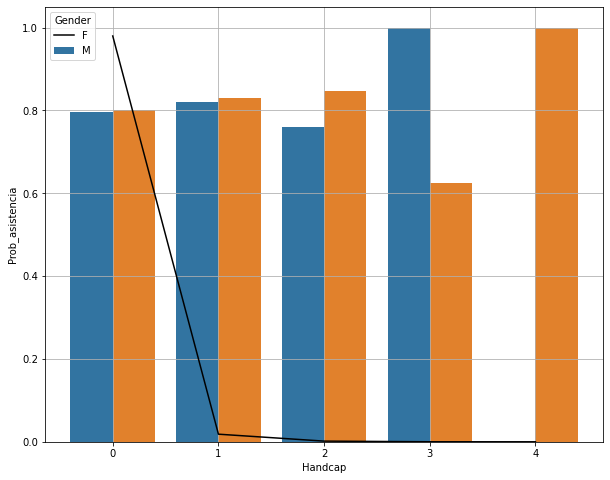

In [35]:
sns.barplot(data = dis, hue = 'Gender', x ='Handcap', y = 'Prob_asistencia')
data.Handcap.value_counts(normalize = True).plot(kind = 'line', grid = True, color = 'black', figsize=(10,8))

## Analisis general de variables categoricas

In [36]:
df_peso = pd.DataFrame(data.groupby(['Alcoholism', 'Gender', 'Diabetes', 'Hipertension','Scholarship', 'SMS_received'], as_index= True).aux.count()/data.aux.sum()).reset_index()

In [37]:
df_peso.head(2)

,Alcoholism,Gender,Diabetes,Hipertension,Scholarship,SMS_received,aux
0,0,F,0,0,0,0,0.150578
1,0,F,0,0,0,1,0.284178


In [38]:
cat = pd.DataFrame(data.groupby(['Alcoholism', 'Gender', 'Diabetes', 'Hipertension','Scholarship', 'SMS_received'], as_index= True)['No_show'].value_counts(normalize = True)).rename(columns={"No_show": "Prob_asistencia"}).reset_index()
df_cat = cat[cat.No_show == 0].drop(columns = 'No_show').sort_values(by = 'Prob_asistencia')
df_cat.head(2)

,Alcoholism,Gender,Diabetes,Hipertension,Scholarship,SMS_received,Prob_asistencia
53,0,M,1,0,1,0,0.333333
69,1,F,0,0,1,0,0.410256


In [39]:
df_cat.merge(df_peso).sort_values(by = 'Prob_asistencia', ascending= False).head(5)

,Alcoholism,Gender,Diabetes,Hipertension,Scholarship,SMS_received,Prob_asistencia,aux
59,1,F,1,0,1,0,1.000000,0.000018
58,1,M,0,1,1,1,0.942857,0.000318
57,0,M,1,1,1,0,0.923077,0.000118
56,1,F,1,1,0,1,0.888889,0.000491
55,1,F,0,1,1,1,0.867769,0.001101


In [40]:
df_cat.merge(df_peso).sort_values(by = 'Prob_asistencia', ascending= False).tail(5)

,Alcoholism,Gender,Diabetes,Hipertension,Scholarship,SMS_received,Prob_asistencia,aux
4,1,M,0,0,1,0,0.583333,0.000109
2,1,M,1,1,1,0,0.500000,0.000018
3,1,F,1,1,1,0,0.500000,0.000036
1,1,F,0,0,1,0,0.410256,0.000710
0,0,M,1,0,1,0,0.333333,0.000027


In [41]:
df_cat.merge(df_peso).sort_values(by = 'aux', ascending= False).head(5)

,Alcoholism,Gender,Diabetes,Hipertension,Scholarship,SMS_received,Prob_asistencia,aux
41,0,F,0,0,0,1,0.834465,0.284178
38,0,M,0,0,0,1,0.828417,0.183853
15,0,F,0,0,0,0,0.719379,0.150578
16,0,M,0,0,0,0,0.719861,0.076003
51,0,F,0,1,0,1,0.861944,0.055231


## Analisis del 80% de los datos

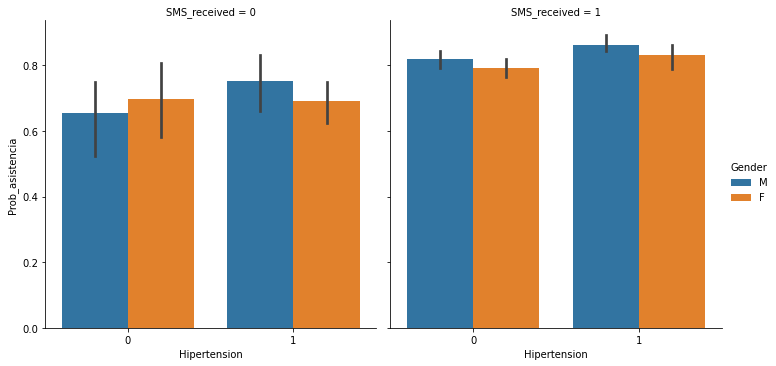

In [42]:
sns.catplot(hue = 'Gender', data = df_cat, y = 'Prob_asistencia', kind = 'bar', col = 'SMS_received', x = 'Hipertension')

# Analisis de Fechas

In [43]:
data.AppointmentDay_month.value_counts(normalize = True)

5    0.73079
6    0.23993
4    0.02928
Name: AppointmentDay_month, dtype: float64

In [44]:
data.groupby(by = 'AppointmentDay_month').No_show.value_counts(normalize = True)

AppointmentDay_month  No_show
4                     0          0.805780
                      1          0.194220
5                     0          0.793067
                      1          0.206933
6                     0          0.815882
                      1          0.184118
Name: No_show, dtype: float64

In [45]:
data.groupby(by = 'AppointmentDay_day_of_week').No_show.value_counts(normalize = True).loc[:,0]

AppointmentDay_day_of_week
Friday       0.788444
Monday       0.794701
Saturday     0.769231
Thursday     0.807197
Tuesday      0.800000
Wednesday    0.803721
Name: No_show, dtype: float64

### Cantidad de turnos por dia de la semana 

<AxesSubplot:xlabel='AppointmentDay_day_of_week', ylabel='aux'>

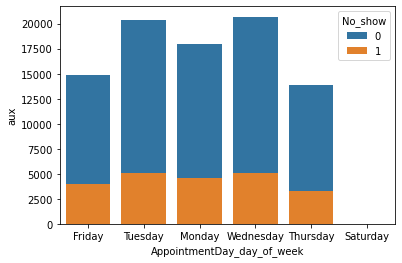

In [46]:
sns.barplot(data = data, x = 'AppointmentDay_day_of_week', y = 'aux', estimator = np.sum, hue = 'No_show', dodge = False)

In [47]:
pd.DataFrame(data.groupby('AppointmentDay_day_of_week').No_show.value_counts(normalize = True)).rename({'No_show':'Percent'}, axis = 1).reset_index().sort_values(['No_show','AppointmentDay_day_of_week'])

,AppointmentDay_day_of_week,No_show,Percent
0,Friday,0,0.788444
2,Monday,0,0.794701
4,Saturday,0,0.769231
6,Thursday,0,0.807197
8,Tuesday,0,0.800000
10,Wednesday,0,0.803721
1,Friday,1,0.211556
3,Monday,1,0.205299
5,Saturday,1,0.230769
7,Thursday,1,0.192803


<AxesSubplot:xlabel='AppointmentDay_day_of_week', ylabel='Percent'>

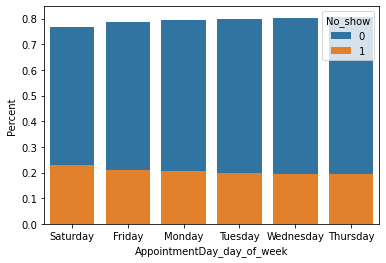

In [48]:
sns.barplot(data =pd.DataFrame(data.groupby('AppointmentDay_day_of_week').No_show.value_counts(normalize = True)).rename({'No_show':'Percent'}, axis = 1).reset_index().sort_values(['No_show','Percent']),
            x='AppointmentDay_day_of_week',
            hue = 'No_show',
            y = 'Percent',
            dodge = False)

In [49]:
g = pd.DataFrame(data.groupby('AppointmentDay_day_of_week').No_show.value_counts(normalize = True)).rename({'No_show':'Percent'}, axis = 1).reset_index().sort_values(['No_show','AppointmentDay_day_of_week'])

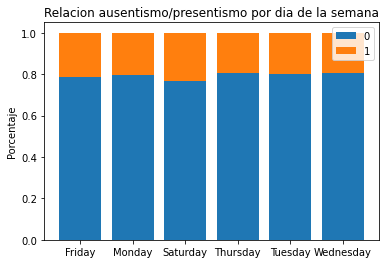

In [50]:
fig, ax = plt.subplots()

ax.bar(x = g[g.No_show == 0].AppointmentDay_day_of_week, height = g[g.No_show == 0].Percent, label = '0')
ax.bar(x = g[g.No_show == 1].AppointmentDay_day_of_week, height = g[g.No_show == 1].Percent, bottom = g[g.No_show == 0].Percent,label = '1')

ax.set_ylabel('Porcentaje')
ax.set_title('Relacion ausentismo/presentismo por dia de la semana')
ax.legend()

plt.show()

### Distribucion de distancia de dias entre Appoiment y Scheduled

<AxesSubplot:xlabel='dbd', ylabel='Count'>

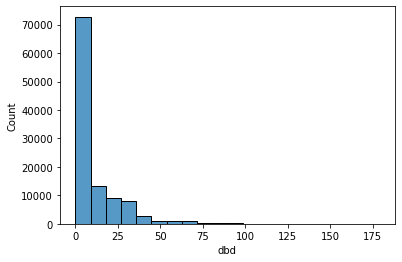

In [51]:
sns.histplot(data = data, x = 'dbd', bins = 20)

<AxesSubplot:xlabel='dbd'>

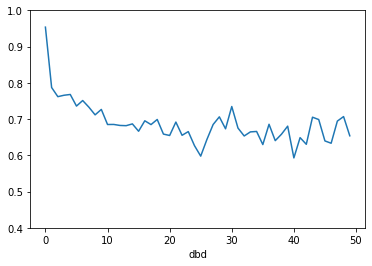

In [52]:
data[data.dbd < 50].groupby('dbd')['No_show'].value_counts(normalize = True).loc[:,0].plot(ylim = (0.4,1))

# Feature Engineering

In [267]:
data.loc[data.Handcap > 0,'Handcap'] = 1

In [268]:
data.Handcap.value_counts()

0    107410
1      2189
Name: Handcap, dtype: int64

In [269]:
age_mask_over = data.Age > 90

In [270]:
data.drop(index=data[age_mask_over].index, inplace= True)

In [271]:
#data['rango_edad'] = pd.cut(data['Age'], [0,6,12,20,25,65,103], right = False, labels=['Infancia 0-6','Ninez 7-12', 'Adolescencia 13-20','Juventud 21-25', 'Adultez 26 - 65', 'Ancianidad >60']) 
data['rango_edad'] = pd.cut(data['Age'], [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,105], right = False)
data['rango_edad'].value_counts(normalize = True).sort_index()

[0, 5)       0.093276
[5, 10)      0.065594
[10, 15)     0.052482
[15, 20)     0.064791
[20, 25)     0.062154
[25, 30)     0.062081
[30, 35)     0.067939
[35, 40)     0.069362
[40, 45)     0.062099
[45, 50)     0.066844
[50, 55)     0.073577
[55, 60)     0.070247
[60, 65)     0.061470
[65, 70)     0.046451
[70, 75)     0.030520
[75, 105)    0.051114
Name: rango_edad, dtype: float64

<AxesSubplot:xlabel='rango_edad'>

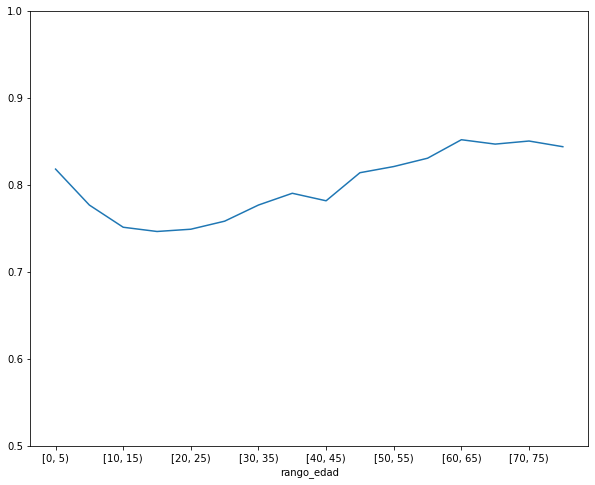

In [272]:
data.groupby('rango_edad').No_show.value_counts(normalize = True).loc[:,0].plot(figsize=(10,8), ylim = (0.5,1))

<AxesSubplot:ylabel='Frequency'>

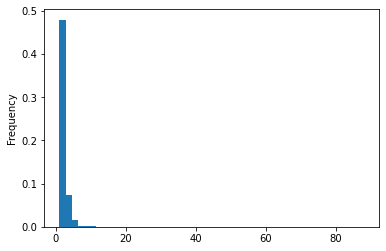

In [273]:
data.PatientId.value_counts().plot.hist(bins = 50, density=True)

<AxesSubplot:xlabel='rango_edad'>

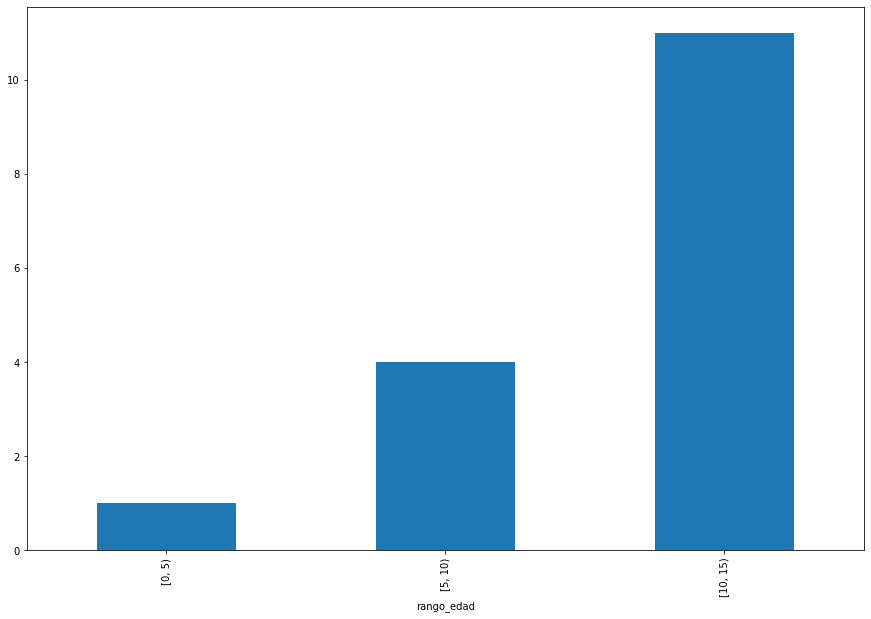

In [274]:
data.groupby('rango_edad').Alcoholism.sum().head(3).plot(kind = 'bar', figsize = (15, 10))

### Se eliminan estos datos de alcoholimo para menores de 20 anos

In [275]:
data = data.drop(index = data[((data.Alcoholism == 1)&((data.rango_edad == 'Infancia 0-6')|(data.rango_edad == 'Ninez 7-12')|(data.rango_edad == 'Adolescencia 13-20')))].index)

In [276]:
def g(row):
    return len(row.unique())

def f(r):
    return r.apply(g)

incon = data.groupby('PatientId')['Age','Gender','Neighbourhood'].apply(f)

In [277]:
incon

,Age,Gender,Neighbourhood
PatientId,,,
39217,1,1,1
43741,1,1,1
93779,1,1,1
141724,1,1,1
537615,1,1,1
...,...,...,...
999931985292928,1,1,1
999934989273974,1,1,1
999946536742891,1,1,1


In [278]:
incon.Age.value_counts()

1    60949
2     1164
Name: Age, dtype: int64

In [279]:
incon.Gender.value_counts()

1    62113
Name: Gender, dtype: int64

In [280]:
incon.Neighbourhood.value_counts()

1    62113
Name: Neighbourhood, dtype: int64

In [281]:
data.groupby('PatientId')['aux'].sum().sort_values(ascending = False).head(20)

PatientId
822145925426128    88
99637671331        84
26886125921145     70
33534783483176     65
871374938638855    62
6264198675331      62
258424392677       62
75797461494159     61
66844879846766     57
872278549442       55
89239687393655     54
8435223536         51
853439686798559    50
65433599726992     46
14479974122994     46
81894521843749     42
9452745294842      42
188232341789524    40
2271579924275      38
9496196639835      38
Name: aux, dtype: int64

In [282]:
data[data.PatientId == 26886125921145].No_show.value_counts()

0    70
Name: No_show, dtype: int64

In [283]:
m = data.groupby('PatientId')['aux'].sum() == 1

In [284]:
data.set_index('PatientId').loc[list(m[m].index),:].No_show.value_counts()

0    30787
1     7150
Name: No_show, dtype: int64

In [285]:
data.set_index('PatientId').loc[list(incon.Age[(incon.Age > 1)].index),:]

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,ScheduledDay_time,...,AppointmentDay_day_of_week,AppointmentDay_day,AppointmentDay_month,AppointmentDay_year,dbd,No_show,aux,rango_edad,App_day,Sche_day
PatientId,,,,,,,,,,,,,,,,,,,,,
22638656,F,22,INHANGUETÁ,0,0,0,0,0,1,2016-04-14 07:23:30+00:00,...,Tuesday,3,5,2016,19,0,1,"[20, 25)",1-10,11-20
22638656,F,23,INHANGUETÁ,0,0,0,0,0,1,2016-05-18 13:37:12+00:00,...,Wednesday,8,6,2016,21,0,1,"[20, 25)",1-10,11-20
1217364296,M,49,MATA DA PRAIA,0,1,0,0,0,1,2016-05-25 14:31:39+00:00,...,Tuesday,31,5,2016,6,0,1,"[45, 50)",20-31,20-31
1217364296,M,48,MATA DA PRAIA,0,1,0,0,0,1,2016-04-06 14:35:40+00:00,...,Thursday,5,5,2016,29,0,1,"[45, 50)",1-10,1-10
1217364296,M,49,MATA DA PRAIA,0,1,0,0,0,0,2016-06-03 08:35:03+00:00,...,Friday,3,6,2016,0,0,1,"[45, 50)",1-10,1-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996868412638744,F,55,TABUAZEIRO,0,0,0,0,0,0,2016-04-28 14:14:16+00:00,...,Friday,29,4,2016,1,0,1,"[55, 60)",20-31,20-31
996868412638744,F,56,TABUAZEIRO,0,0,0,0,0,1,2016-04-25 15:06:32+00:00,...,Wednesday,1,6,2016,37,0,1,"[55, 60)",1-10,20-31
999479168794227,M,44,RESISTÊNCIA,0,0,0,0,0,1,2016-04-25 11:42:54+00:00,...,Monday,2,5,2016,7,1,1,"[40, 45)",1-10,20-31


In [286]:
data['App_day'] = pd.cut(data['AppointmentDay_day'], [0,10,20,32], right = False, labels=['1-10','11-20', '20-31']) 
data['Sche_day'] = pd.cut(data['ScheduledDay_day'], [0,10,20,32], right = False, labels=['1-10','11-20', '20-31']) 

## Historial de persentismo por paciente

In [287]:
d = data.sort_values(['PatientId','AppointmentDay_time'])

In [288]:
d['cant_faltas'] = d.groupby("PatientId")['No_show'].cumsum()

In [289]:
d['cant_app'] = d.groupby("PatientId")['aux'].cumsum()

In [290]:
d[d.PatientId == 131413946716122]

,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,...,AppointmentDay_month,AppointmentDay_year,dbd,No_show,aux,rango_edad,App_day,Sche_day,cant_faltas,cant_app
1404,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,4,2016,2,0,1,"[45, 50)",20-31,20-31,0,1
32234,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,5,2016,0,0,1,"[45, 50)",1-10,1-10,0,2
32143,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,5,2016,0,0,1,"[45, 50)",1-10,1-10,0,3
32232,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,5,2016,9,1,1,"[45, 50)",11-20,1-10,1,4
32260,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,5,2016,0,0,1,"[45, 50)",20-31,20-31,1,5
32218,131413946716122,F,48,JABOUR,0,0,0,0,0,1,...,5,2016,5,0,1,"[45, 50)",20-31,20-31,1,6
101326,131413946716122,F,48,JABOUR,0,0,0,0,0,1,...,6,2016,28,1,1,"[45, 50)",1-10,1-10,2,7


In [291]:
datos = d.groupby(['PatientId','cant_faltas']).head(1)

In [292]:
datos_corregidos = datos.cant_faltas.transform(lambda x : x-1 if (x>0) else x)

In [293]:
d.loc[datos_corregidos.index, 'cant_faltas'] = datos_corregidos

In [294]:
d[d.PatientId == 131413946716122]

,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,...,AppointmentDay_month,AppointmentDay_year,dbd,No_show,aux,rango_edad,App_day,Sche_day,cant_faltas,cant_app
1404,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,4,2016,2,0,1,"[45, 50)",20-31,20-31,0,1
32234,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,5,2016,0,0,1,"[45, 50)",1-10,1-10,0,2
32143,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,5,2016,0,0,1,"[45, 50)",1-10,1-10,0,3
32232,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,5,2016,9,1,1,"[45, 50)",11-20,1-10,0,4
32260,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,5,2016,0,0,1,"[45, 50)",20-31,20-31,1,5
32218,131413946716122,F,48,JABOUR,0,0,0,0,0,1,...,5,2016,5,0,1,"[45, 50)",20-31,20-31,1,6
101326,131413946716122,F,48,JABOUR,0,0,0,0,0,1,...,6,2016,28,1,1,"[45, 50)",1-10,1-10,1,7


In [295]:
d['can_asist'] = (d['cant_app'] - 1 - d['cant_faltas'])

In [296]:
d[d.PatientId == 131413946716122]

,PatientId,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,...,AppointmentDay_year,dbd,No_show,aux,rango_edad,App_day,Sche_day,cant_faltas,cant_app,can_asist
1404,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,2016,2,0,1,"[45, 50)",20-31,20-31,0,1,0
32234,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,2016,0,0,1,"[45, 50)",1-10,1-10,0,2,1
32143,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,2016,0,0,1,"[45, 50)",1-10,1-10,0,3,2
32232,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,2016,9,1,1,"[45, 50)",11-20,1-10,0,4,3
32260,131413946716122,F,48,JABOUR,0,0,0,0,0,0,...,2016,0,0,1,"[45, 50)",20-31,20-31,1,5,3
32218,131413946716122,F,48,JABOUR,0,0,0,0,0,1,...,2016,5,0,1,"[45, 50)",20-31,20-31,1,6,4
101326,131413946716122,F,48,JABOUR,0,0,0,0,0,1,...,2016,28,1,1,"[45, 50)",1-10,1-10,1,7,5


In [297]:
d['App_day'] = pd.cut(d['AppointmentDay_day'], [0,10,20,32], right = False, labels=['1-10','11-20', '20-31']) 
d['Sche_day'] = pd.cut(d['ScheduledDay_day'], [0,10,20,32], right = False, labels=['1-10','11-20', '20-31']) 

## X-y Split

In [298]:
X = d.drop(columns = ['PatientId',
                         'No_show',
                         'Neighbourhood',
                         'ScheduledDay_time',
                         'ScheduledDay_day',
                         'ScheduledDay_month',
                         'ScheduledDay_year',
                         'AppointmentDay_time',
                         'AppointmentDay_day',
                         'AppointmentDay_month', 
                         'AppointmentDay_year',
                         'aux', 'Age'])
               
y = d.No_show

<AxesSubplot:>

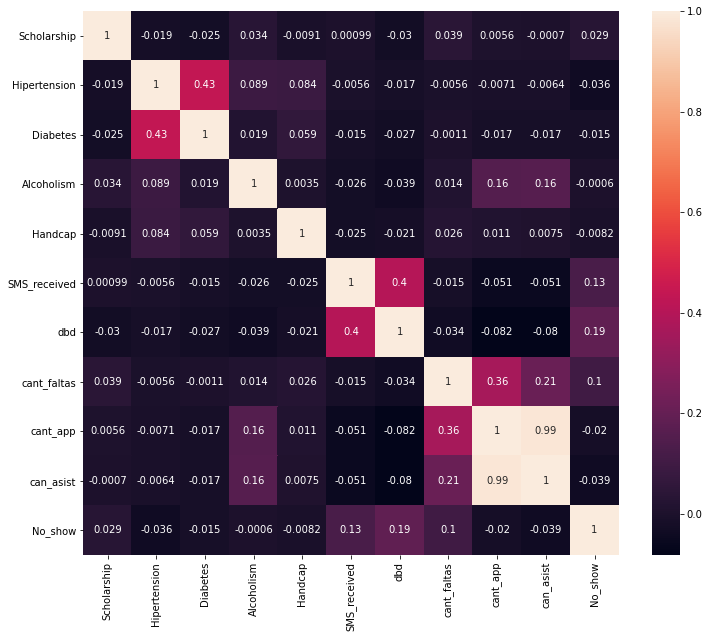

In [299]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,10)

sns.heatmap(X.join(y).corr(), annot = True)

## Train-Test Split

In [300]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 1)

## Baseline

In [301]:
dclass = DummyClassifier()

In [302]:
dclass.fit(X_train, y_train)

DummyClassifier()

In [303]:
print(classification_report(y_test, dclass.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     21890
           1       0.21      0.21      0.21      5510

    accuracy                           0.68     27400
   macro avg       0.50      0.50      0.50     27400
weighted avg       0.68      0.68      0.68     27400



### F-Beta Score (beta = 2)

In [304]:
fbeta_score(y_test, dclass.predict(X_test), 2)

0.20324760244115078

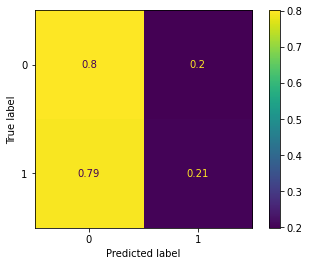

In [305]:
plot_confusion_matrix(dclass,y_test, dclass.predict(X_test), normalize = 'true')

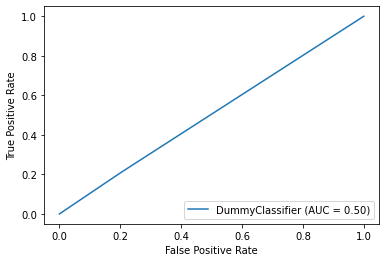

In [306]:
plot_roc_curve(dclass, X_test, y_test) 

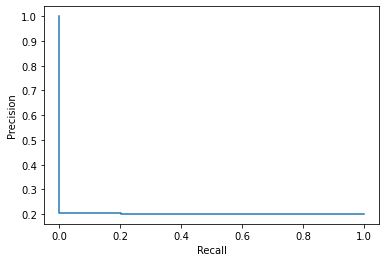

In [307]:
predictions = dclass.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, predictions)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

plt.show()

## Clasificacion de Features

In [308]:
cat_features = ['Gender', 'ScheduledDay_day_of_week', 'AppointmentDay_day_of_week','App_day','Sche_day','rango_edad']
num_features = [ 'cant_faltas', 'cant_app', 'can_asist','dbd']
cat_dum_features = ['Scholarship', 'Hipertension', 'Diabetes',  'Alcoholism', 'Handcap', 'SMS_received']

## Pipelines y Tranfsormers

In [309]:
#Balancer
sm = SMOTENC(categorical_features = X_train.columns.isin(cat_features + cat_dum_features))
os = RandomOverSampler()
us = RandomUnderSampler()

# Categorical pipeline
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Numerical pipeline
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_features),
    ('num', num_pipe, num_features)
], remainder='passthrough')

cv = StratifiedKFold(n_splits = 2, shuffle = True, random_state = 1)

score_ = make_scorer(fbeta_score, beta=2) 

### RandomForestClassifier Pipe

In [128]:
model_RFC = RandomForestClassifier()

#Pipeline
pipe_RFC = Pipeline([
    ('balancer', os),
    ('preprocessor', preprocessor),
    ('clasificador', model_RFC)])

#Params
param_grid_RFC = {'balancer' : [us],
              'balancer__sampling_strategy': ['auto', 0.6],
              'clasificador__criterion' : ["gini", "entropy"],
              'clasificador__n_estimators' : [100, 1000],
              'clasificador__class_weight':['balanced', None],
              'clasificador__min_samples_leaf':[1,2]
             }
#Grid
grid_RFC_2 = GridSearchCV(pipe_RFC, param_grid = param_grid_RFC, n_jobs = -1, cv = cv, scoring = score_, verbose = 1)

In [129]:
grid_RFC_2.fit(X_train, y_train)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  5.1min finished


[CV] clasificador__weights=uniform, clasificador__algorithm=brute, balancer__sampling_strategy=0.6, balancer=RandomUnderSampler() 
[CV]  clasificador__weights=uniform, clasificador__algorithm=brute, balancer__sampling_strategy=0.6, balancer=RandomUnderSampler(), total= 2.9min


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('balancer', RandomOverSampler()),
                                       ('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'ScheduledDay_day_of_week',
                                                                          'AppointmentDay_day_of_week',
                                                                          'App_...
                                       ('clasificador',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'balancer': [RandomUnderSampler()],
                         'balancer__sampling_strategy': ['auto', 0.6],
                         'clasificador__class_weight': ['balanced', None],
                         'clasificador__criterion': ['gini', 'entropy'],
                         'clasificador__min_samples_leaf': [1, 2],
                         'clasificador__n_estimators': [100, 1000]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

### XGboost Pipe

In [130]:
model_XGBC = xgb.XGBClassifier(eval_metric = 'logloss', use_label_encoder = False)

pipe_XGBC= Pipeline([
    ('balancer', os),
    ('preprocessor', preprocessor),
    ('clasificador', model_XGBC)])

param_grid_XGBC = {'balancer': [us],
                   'balancer__sampling_strategy': ['auto',0.6],
                   'clasificador__learning_rate': [0.01, 0.3],
                   'clasificador__max_depth': [3,6],
                   'clasificador__n_estimators' : [100, 1000]
}

grid_XGBC_2 = GridSearchCV(pipe_XGBC, param_grid = param_grid_XGBC, n_jobs = -1, cv = cv, scoring = score_, verbose = 1)


In [131]:
grid_XGBC_2.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  4.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('balancer', RandomOverSampler()),
                                       ('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'ScheduledDay_day_of_week',
                                                                          'AppointmentDay_day_of_week',
                                                                          'App_...
                                                      subsample=None,
                                                      tree_method=None,
                                                      use_label_encoder=False,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             n_jobs=-1,
             param_grid={'balancer': [RandomUnderSampler()],
                         'balancer__sampling_strategy': ['auto', 0.6],
                         'clasificador__learning_rate': [0.01, 0.3],
                         'clasificador__max_depth': [3, 6],
                         'clasificador__n_estimators': [100, 1000]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

### LogisticRegression Pipe

In [132]:
model_LR = LogisticRegression()

pipe_LR= Pipeline([
    ('balancer', os),
    ('preprocessor', preprocessor),
    ('clasificador', model_LR)])

param_grid_LR = {'balancer': [us],
                  'balancer__sampling_strategy': [0.6, 'auto'],
                 'clasificador__fit_intercept': [True, False],
                 'clasificador__class_weight': [None, 'balanced']
                 
                 }

grid_LR_2 = GridSearchCV(pipe_LR, param_grid = param_grid_LR, n_jobs = -1, cv = cv, scoring = score_, verbose = 1)

In [133]:
grid_LR_2.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    3.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('balancer', RandomOverSampler()),
                                       ('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'ScheduledDay_day_of_week',
                                                                          'AppointmentDay_day_of_week',
                                                                          'App_...
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['cant_faltas',
                                                                          'cant_app',
                                                                          'can_asist',
                                                                          'dbd'])])),
                                       ('clasificador', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'balancer': [RandomUnderSampler()],
                         'balancer__sampling_strategy': [0.6, 'auto'],
                         'clasificador__class_weight': [None, 'balanced'],
                         'clasificador__fit_intercept': [True, False]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

### BernoulliNB Pipe

In [134]:
model_NB = BernoulliNB()

pipe_NB= Pipeline([
    ('balancer', os),
    ('preprocessor', preprocessor),
    ('clasificador', model_NB)])

param_grid_NB = {'balancer': [us],
                  'balancer__sampling_strategy': [0.6, 'auto'], 
                 'clasificador__alpha': [0.5, 1],
                 'clasificador__fit_prior': [True, False]
                 }

grid_NB_2 = GridSearchCV(pipe_NB, param_grid = param_grid_NB, n_jobs = -1, cv = cv, scoring = score_, verbose = 1)

In [135]:
grid_NB_2.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    3.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('balancer', RandomOverSampler()),
                                       ('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'ScheduledDay_day_of_week',
                                                                          'AppointmentDay_day_of_week',
                                                                          'App_...
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['cant_faltas',
                                                                          'cant_app',
                                                                          'can_asist',
                                                                          'dbd'])])),
                                       ('clasificador', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'balancer': [RandomUnderSampler(sampling_strategy=0.6)],
                         'balancer__sampling_strategy': [0.6, 'auto'],
                         'clasificador__alpha': [0.5, 1],
                         'clasificador__fit_prior': [True, False]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

### AdaBoostClassifier Pipe

In [136]:
model_ADA = AdaBoostClassifier()

pipe_ADA = Pipeline([
    ('balancer', os),
    ('preprocessor', preprocessor),
    ('clasificador', model_ADA)])

param_grid_ADA = {'balancer': [us],
                  'balancer__sampling_strategy': [0.6,'auto'],
                  'clasificador__n_estimators':[50, 100, 1000, 10000],
                  'clasificador__learning_rate':[0.01, 0.1, 1]
                  }

grid_ADA_2 = GridSearchCV(pipe_ADA, param_grid = param_grid_ADA, n_jobs = -1, cv = cv, scoring = score_, verbose = 1)

In [137]:
grid_ADA_2.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 11.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('balancer', RandomOverSampler()),
                                       ('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'ScheduledDay_day_of_week',
                                                                          'AppointmentDay_day_of_week',
                                                                          'App_...
                                                                                          StandardScaler())]),
                                                                         ['cant_faltas',
                                                                          'cant_app',
                                                                          'can_asist',
                                                                          'dbd'])])),
                                       ('clasificador', AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'balancer': [RandomUnderSampler()],
                         'balancer__sampling_strategy': [0.6, 'auto'],
                         'clasificador__learning_rate': [0.01, 0.1, 1],
                         'clasificador__n_estimators': [50, 100, 1000, 10000]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

### KNeighborsClassifier Pipe

In [138]:
model_KNN = KNeighborsClassifier()

pipe_KNN= Pipeline([
    ('balancer', os),
    ('preprocessor', preprocessor),
    ('clasificador', model_KNN)])

param_grid_KNN = {'balancer': [us],
                  'balancer__sampling_strategy': [0.6, 'auto'],
                  'clasificador__weights':['uniform', 'distance'],
                  'clasificador__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
                 }

grid_KNN_2 = RandomizedSearchCV(pipe_KNN, param_distributions = param_grid_KNN, n_jobs = -1, cv = cv, scoring = score_, verbose = 2)

In [139]:
grid_KNN_2.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  3.0min remaining:   45.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.4min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('balancer', RandomOverSampler()),
                                             ('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Gender',
                                                                                'ScheduledDay_day_of_week',
                                                                                'AppointmentDay_day_of_week'...
                                                                               ['cant_faltas',
                                                                                'cant_app',
                                                                                'can_asist',
                                                                                'dbd'])])),
                                             ('clasificador',
                                              KNeighborsClassifier())]),
                   n_jobs=-1,
                   param_distributions={'balancer': [RandomUnderSampler()],
                                        'balancer__sampling_strategy': [0.6,
                                                                        'auto'],
                                        'clasificador__algorithm': ['auto',
                                                                    'ball_tree',
                                                                    'kd_tree',
                                                                    'brute'],
                                        'clasificador__weights': ['uniform',
                                                                  'distance']},
                   scoring=make_scorer(fbeta_score, beta=2), verbose=2)

### LGBMClassifier Pipe

In [310]:
model_LGBM = LGBMClassifier(objective='binary')

pipe_LGBM= Pipeline([
    ('balancer', os),
    ('preprocessor', preprocessor),
    ('clasificador', model_LGBM)])

param_grid_LGBM = {'balancer': [us,os],
                  'balancer__sampling_strategy': [0.6, 'auto'],
                  'clasificador__learning_rate':[0.1, 0.01, 1],
                  'clasificador__num_leaves': [30,60],
                  'clasificador__max_depth': [6,-1],
                  'clasificador__n_estimators':[100,1000],
                  'clasificador__class_weight': ['balanced', None]
                 }

grid_LGBM_2 = GridSearchCV(pipe_LGBM, param_grid = param_grid_LGBM, n_jobs = -1, cv = cv, scoring = score_, verbose = 1)

In [311]:
grid_LGBM_2.fit(X_train, y_train)

Fitting 2 folds for each of 192 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  5.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('balancer', RandomOverSampler()),
                                       ('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'ScheduledDay_day_of_week',
                                                                          'AppointmentDay_day_of_week',
                                                                          'App_...
             param_grid={'balancer': [RandomUnderSampler(),
                                      RandomOverSampler()],
                         'balancer__sampling_strategy': [0.6, 'auto'],
                         'clasificador__class_weight': ['balanced', None],
                         'clasificador__learning_rate': [0.1, 0.01, 1],
                         'clasificador__max_depth': [6, -1],
                         'clasificador__n_estimators': [100, 1000],
                         'clasificador__num_leaves': [30, 60]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

### CatBoostClassifier Pipe

In [155]:
model_CBC = CatBoostClassifier(verbose = False)

pipe_CBC = Pipeline([
    ('balancer', os),
    ('preprocessor', preprocessor),
    ('clasificador', model_CBC)])

param_grid_CBC = {'balancer': [us],
                  'balancer__sampling_strategy': [0.6,'auto'],
                  'clasificador__learning_rate':[0.1, 0.01, 0.1],
                  'clasificador__bagging_temperature': [10,100],
                  'clasificador__depth': [5,10],
                  'clasificador__iterations':[100, 1000]
                 }

grid_CBC_2 = RandomizedSearchCV(pipe_CBC, param_distributions = param_grid_CBC, n_jobs = -1, cv = cv, scoring = score_, verbose = 1)

In [156]:
grid_CBC_2.fit(X_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.3min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('balancer', RandomOverSampler()),
                                             ('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Gender',
                                                                                'ScheduledDay_day_of_week',
                                                                                'AppointmentDay_day_of_week'...
                                              <catboost.core.CatBoostClassifier object at 0x7f917ae03910>)]),
                   n_jobs=-1,
                   param_distributions={'balancer': [RandomUnderSampler()],
                                        'balancer__sampling_strategy': [0.6,
                                                                        'auto'],
                                        'clasificador__bagging_temperature': [10,
                                                                              100],
                                        'clasificador__depth': [5, 10],
                                        'clasificador__iterations': [100, 1000],
                                        'clasificador__learning_rate': [0.1,
                                                                        0.01,
                                                                        0.1]},
                   scoring=make_scorer(fbeta_score, beta=2), verbose=1)

### Grid List

In [312]:
grids_2 = {'AdaBoost':grid_ADA_2,
         'CatBoost':grid_CBC_2,
         'LightGBM':grid_LGBM_2,
         'LogisticRegression':grid_LR_2,
         'NaiveBayes':grid_NB_2,
         'Random Forest': grid_RFC_2,
         'XGBoost':grid_XGBC_2,
         'Knn' : grid_KNN_2
        }

## Scores

In [313]:
recalls_train = []
precisions_train = []
fbetas_train = []

for k in grids_2.keys():
    y_pred = grids_2[k].predict(X_train)
    score = recall_score(y_train, y_pred)
    recalls_train.append(score)
    score = precision_score(y_train, y_pred)
    precisions_train.append(score)
    score = fbeta_score(y_train, y_pred, beta = 2)
    fbetas_train.append(score)

In [314]:
recalls_test = []
precisions_test = []
fbetas_test = []

for k in grids_2.keys():
    y_pred = grids_2[k].predict(X_test)
    score = recall_score(y_test, y_pred)
    recalls_test.append(score)
    score = precision_score(y_test, y_pred)
    precisions_test.append(score)
    score = fbeta_score(y_test, y_pred, beta = 2)
    fbetas_test.append(score)

(0.0, 1.1)

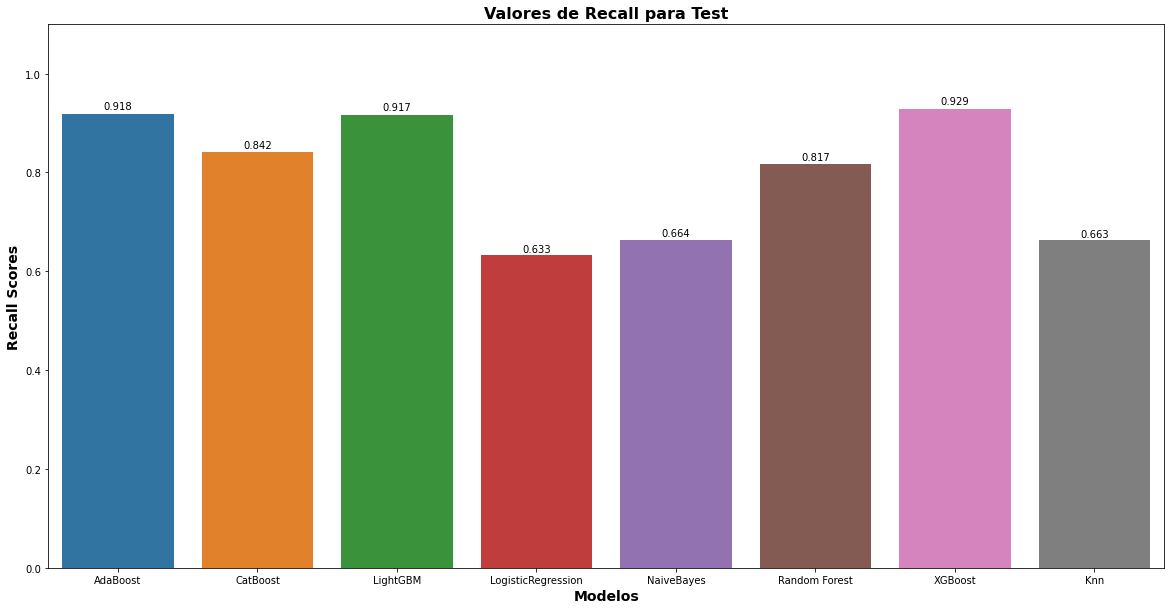

In [315]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x = list(grids_2.keys()), y = recalls_test)
plt.xlabel('Modelos', fontweight='bold', color = 'Black', fontsize='14')
plt.ylabel('Recall Scores', fontweight='bold', color = 'Black', fontsize='14')
show_values(ax)
ax.set_title('Valores de Recall para Test',fontweight ='bold', fontsize ='16')
ax.set_ylim(0,1.1)

(0.0, 1.0)

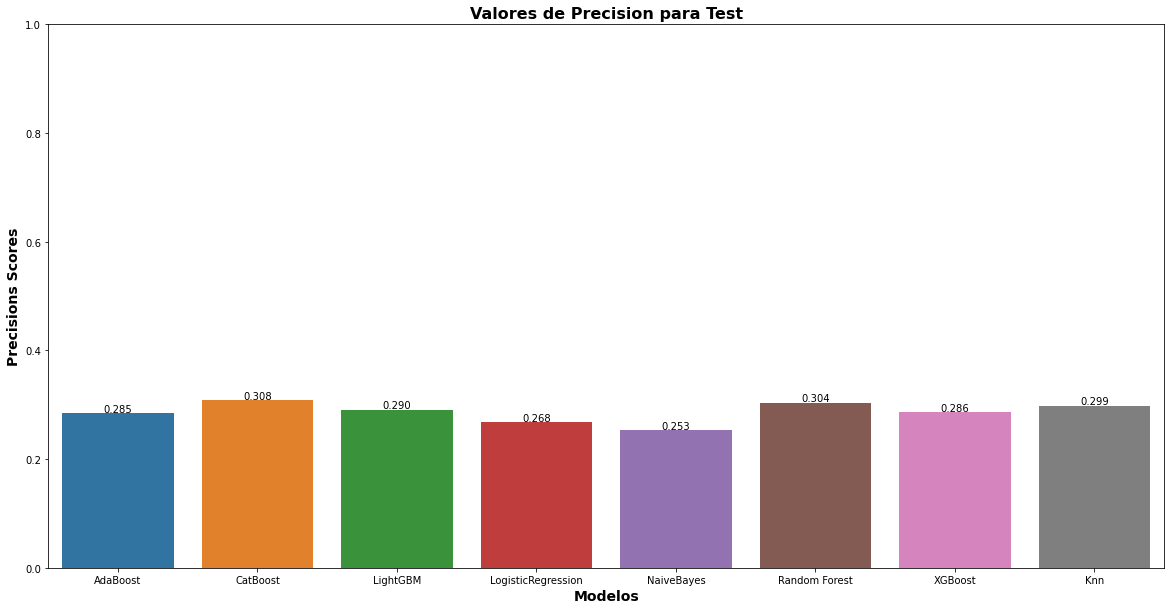

In [316]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x = list(grids_2.keys()), y = precisions_test)
plt.xlabel('Modelos', fontweight='bold', color = 'Black', fontsize='14')
plt.ylabel('Precisions Scores', fontweight='bold', color = 'Black', fontsize='14')
show_values(ax)
ax.set_title('Valores de Precision para Test',fontweight ='bold', fontsize ='16')
ax.set_ylim(0,1)

In [317]:
scores_2 = pd.DataFrame({
          'recalls_train':recalls_train,
          'recalls_test':recalls_test,
          'precisions_train':precisions_train,
          'precisions_test':precisions_test,
          'fbeta_train':fbetas_train,
          'fbeta_test':fbetas_test
         }, index = list(grids_2.keys()))
scores_2

,recalls_train,recalls_test,precisions_train,precisions_test,fbeta_train,fbeta_test
AdaBoost,0.919666,0.918330,0.284535,0.284605,0.635816,0.635375
CatBoost,0.868792,0.841924,0.316602,0.308239,0.644111,0.625371
LightGBM,0.919848,0.917241,0.290296,0.290443,0.641576,0.640704
LogisticRegression,0.630875,0.633031,0.264716,0.267772,0.494167,0.497348
NaiveBayes,0.646059,0.664247,0.246777,0.252885,0.488108,0.501191
Random Forest,0.884762,0.817060,0.329927,0.303717,0.662080,0.610639
XGBoost,0.928619,0.929038,0.285685,0.286474,0.640383,0.641334
Knn,0.777569,0.663339,0.348640,0.298514,0.624023,0.533047


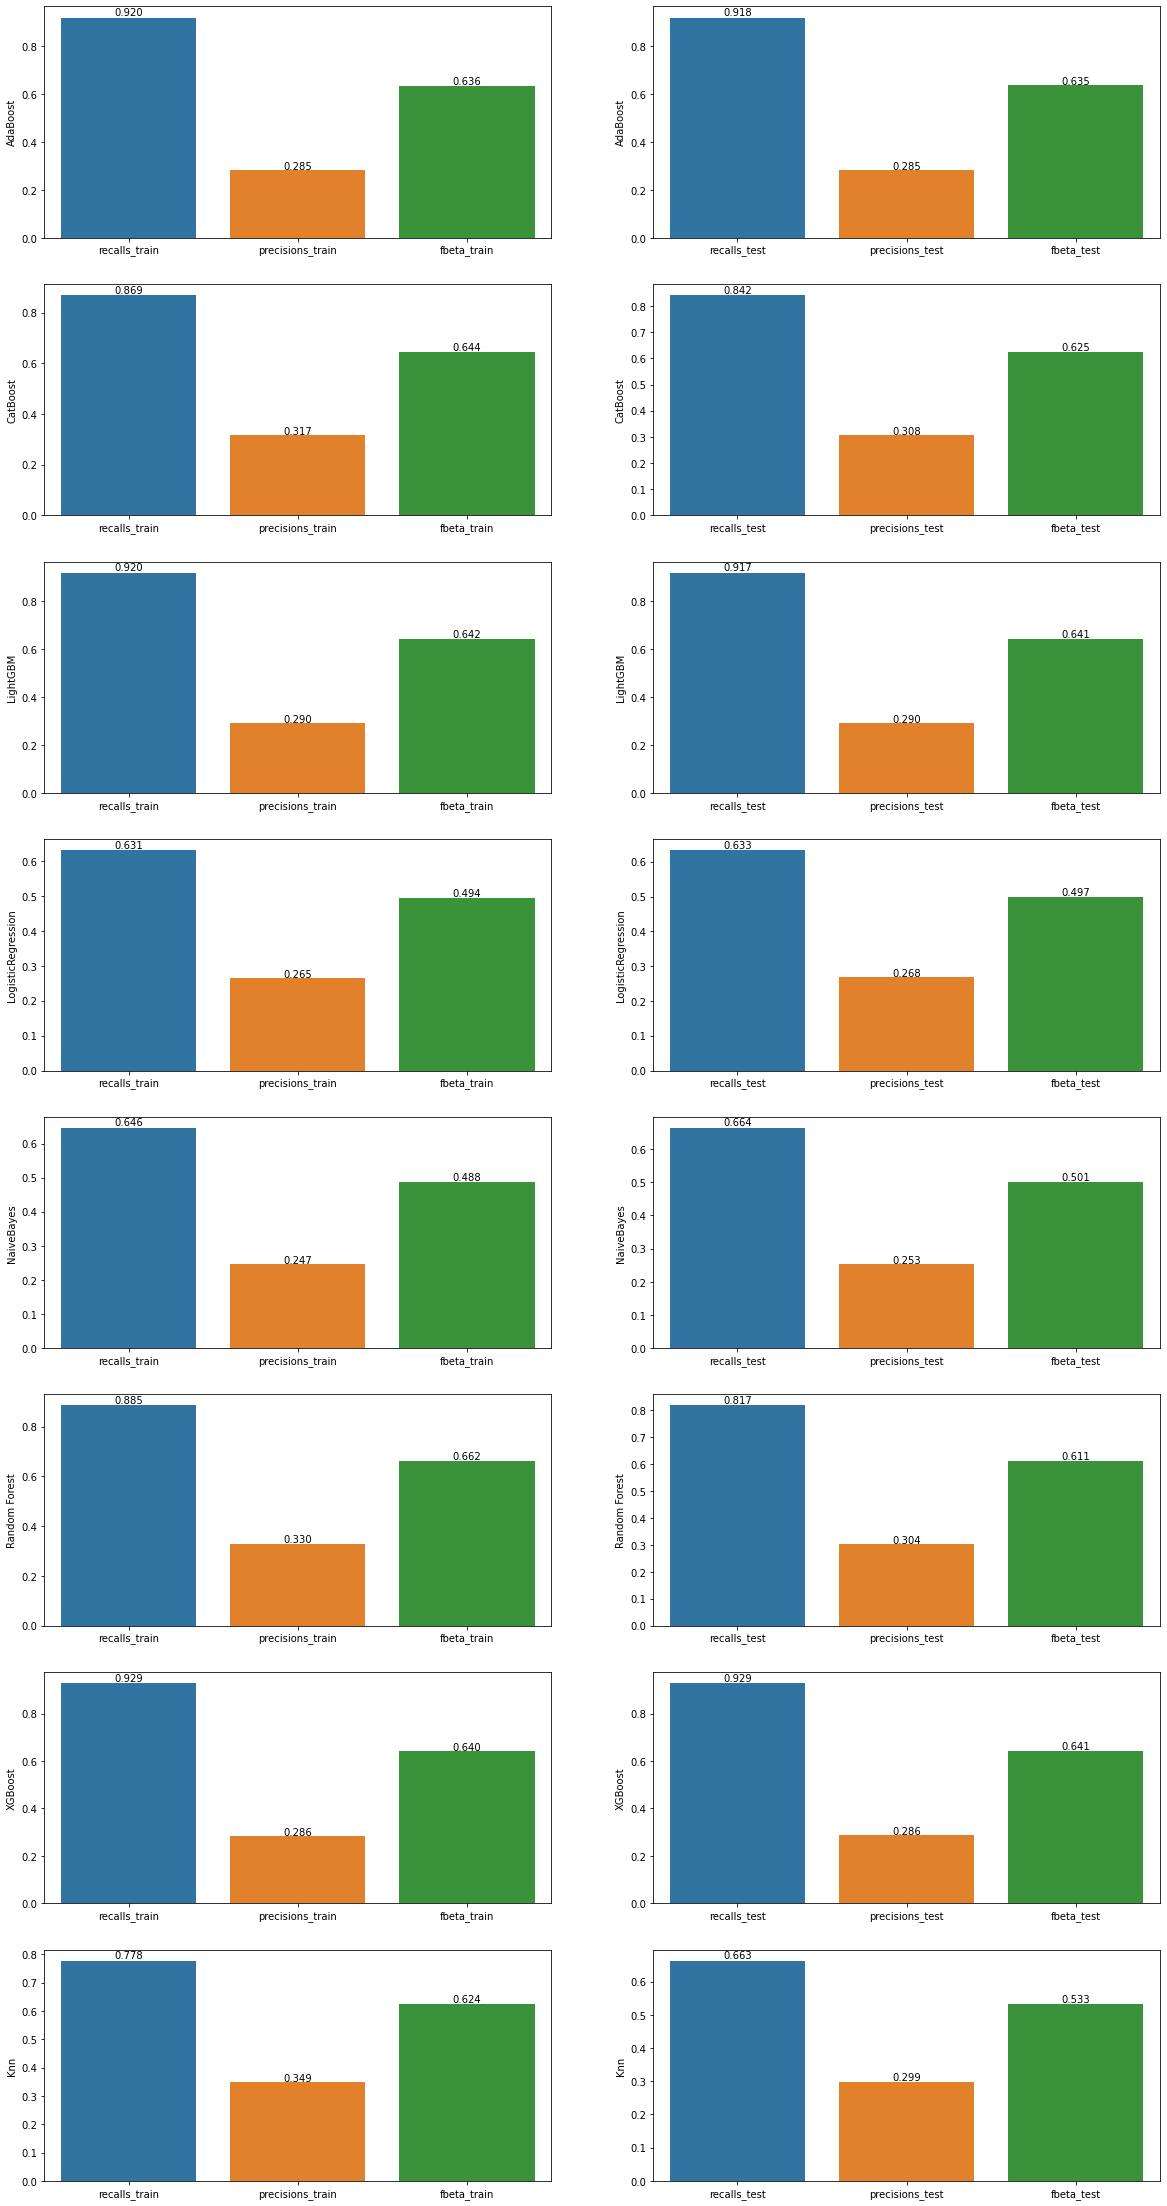

In [318]:
columns = [['recalls_train', 'precisions_train', 'fbeta_train'],['recalls_test', 'precisions_test', 'fbeta_test']]

fig, axs = plt.subplots(len(scores_2.index), 2)
fig.set_figheight(40)
fig.set_figwidth(20)
for i, ax in enumerate(axs.flat):
    sns.barplot(x= columns[i%2], y = scores_2.loc[scores_2.index[int(i/2)],columns[i%2]], ax=ax)
    show_values(ax)

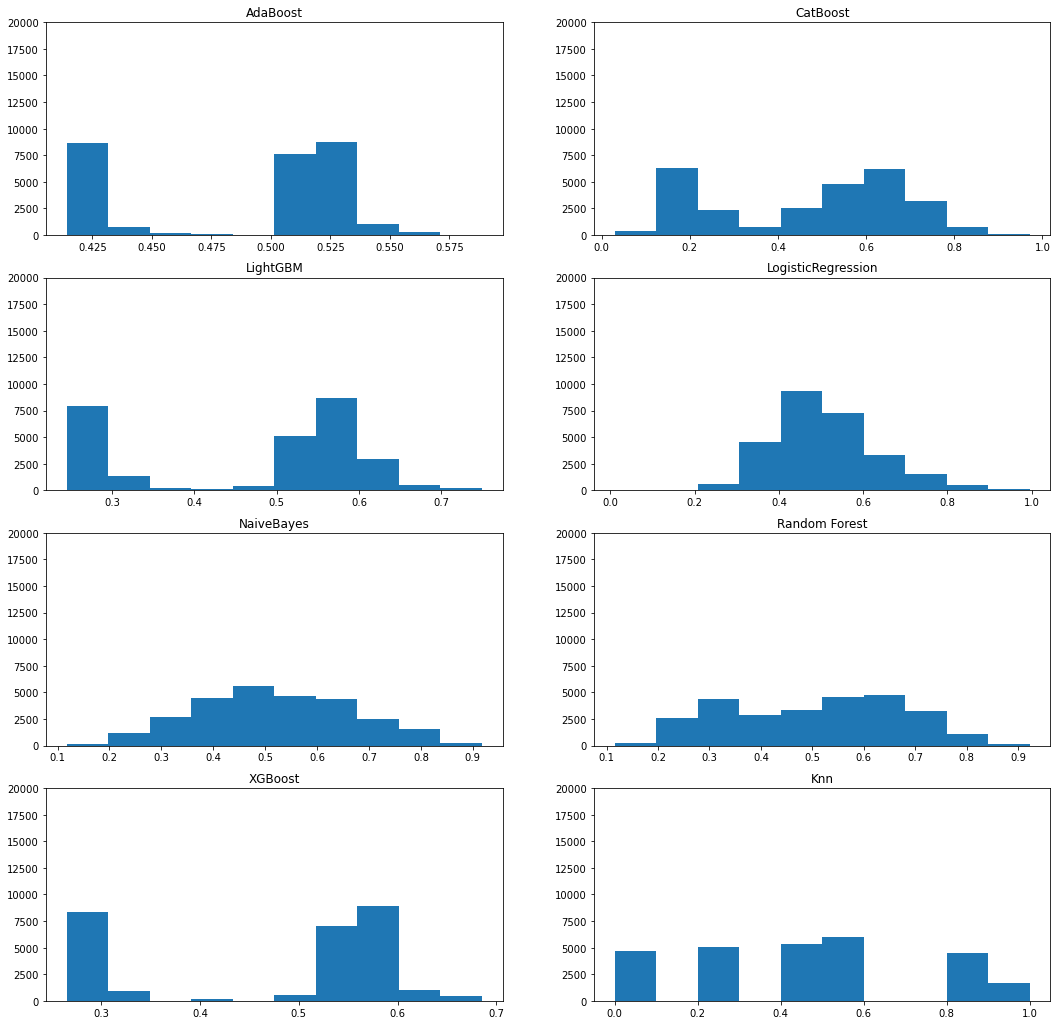

In [319]:
fig, axs = plt.subplots(4, 2, figsize=(18,18))
fig.figsize = (10,10)
for n, model in enumerate(grids_2.keys()):
    y_pred_proba1 = grids_2[model].predict_proba(X_test)
    y_probs_logit_left = y_pred_proba1[:,1]
    title = model
    axs[int(n/2),n%2].set_ylim(ymin = 0, ymax = 20000)
    axs[int(n/2),n%2].set_title(str(title))
    axs[int(n/2),n%2].hist(y_probs_logit_left, bins = 10)

# XGBoost

## Features Importances 

<AxesSubplot:>

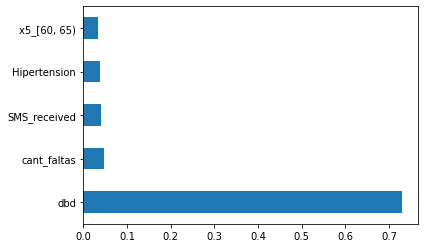

In [320]:
(pd.Series(grids_2['XGBoost'].best_estimator_.named_steps['clasificador'].feature_importances_, index=list(grids_2['XGBoost'].best_estimator_.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names())+num_features+cat_dum_features)
   .nlargest(5)
   .plot(kind='barh')) 

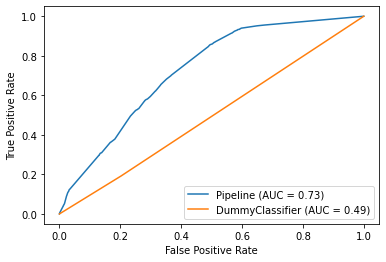

In [321]:
fig, ax = plt.subplots()
plot_roc_curve(grids_2['XGBoost'].best_estimator_, X_test, y_test, ax = ax)
plot_roc_curve(dclass, X_test, y_test, ax = ax) 

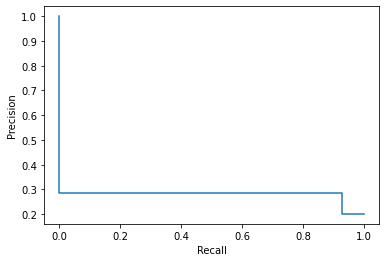

In [322]:
precision, recall, _ = precision_recall_curve(y_test, grids_2['XGBoost'].best_estimator_.predict(X_test))
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

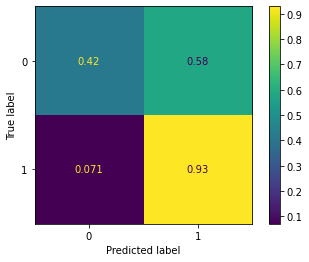

In [323]:
plot_confusion_matrix(estimator = grids_2['XGBoost'].best_estimator_, X = X_test, y_true = y_test, normalize = 'true')

In [324]:
print(classification_report(y_test, grids_2['XGBoost'].best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.42      0.58     21890
           1       0.29      0.93      0.44      5510

    accuracy                           0.52     27400
   macro avg       0.62      0.67      0.51     27400
weighted avg       0.82      0.52      0.55     27400



In [325]:
recall_t = []

for t in np.arange(0,1.01,0.01):
    y_pred = (grids_2['XGBoost'].predict_proba(X_test)[:,1]>t).astype(int)
    recall_t.append(recall_score(y_test,y_pred))   

In [326]:
precision_t = []

for t in np.arange(0,1.01,0.01):
    y_pred = (grids_2['XGBoost'].predict_proba(X_test)[:,1]>t).astype(int)
    precision_t.append(precision_score(y_test,y_pred))

[Text(0, 0.5, 'Valor de Metrica'), Text(0.5, 0, 'Threshold')]

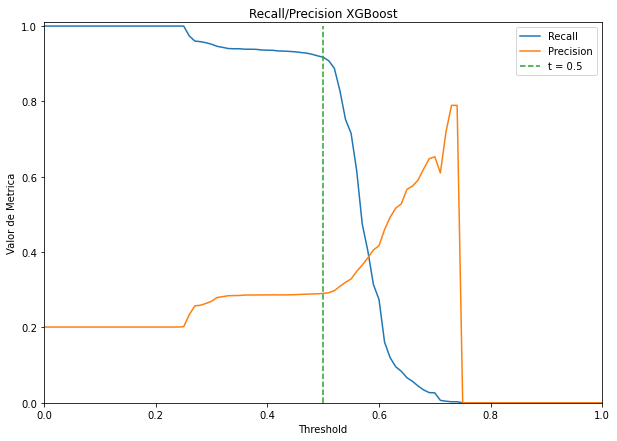

In [363]:
fig, axs = plt.subplots(1, 1, figsize=(10,7))

title = 'Recall/Precision XGBoost'
axs.set_ylim(ymin = 0, ymax =1.01)
axs.set_xlim(xmin = 0, xmax =1)
axs.set_title(title)
axs.plot(np.arange(0,1.01,0.01), recall_t, label = 'Recall')
axs.plot(np.arange(0,1.01,0.01), precision_t, label = 'Precision')
axs.plot(np.ones(101)*0.5,np.arange(0,1.01,0.01), label = 't = 0.5', linestyle = '--')
axs.legend()
axs.set(ylabel='Valor de Metrica', xlabel='Threshold')

# LightGBM

## Features Importances

<AxesSubplot:>

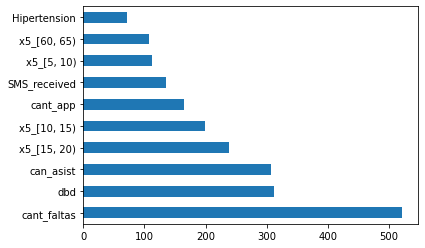

In [328]:
(pd.Series(grids_2['LightGBM'].best_estimator_.named_steps['clasificador'].feature_importances_, index=list(grids_2['LightGBM'].best_estimator_.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names())+num_features+cat_dum_features)
   .nlargest(10)
   .plot(kind='barh')) 

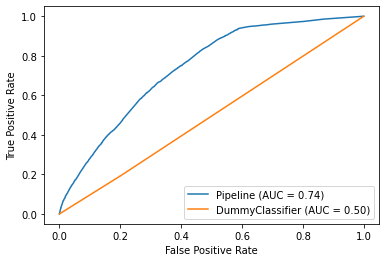

In [329]:
fig, ax = plt.subplots()
plot_roc_curve(grids_2['LightGBM'].best_estimator_, X_test, y_test, ax = ax)
plot_roc_curve(dclass, X_test, y_test, ax = ax) 

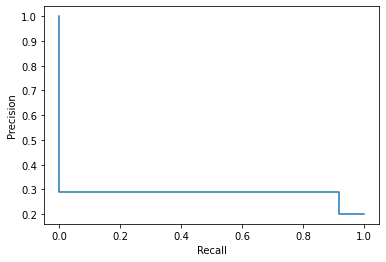

In [330]:
precision, recall, _ = precision_recall_curve(y_test, grids_2['LightGBM'].best_estimator_.predict(X_test))
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

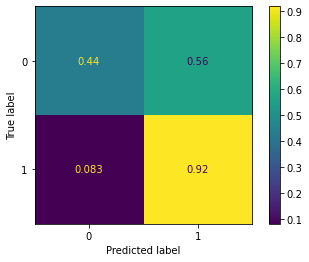

In [331]:
plot_confusion_matrix(estimator = grids_2['LightGBM'].best_estimator_, X = X_test, y_true = y_test, normalize = 'true' )

In [332]:
cf_matrix = confusion_matrix(y_test, grids_2['LightGBM'].best_estimator_.predict(X_test))

In [333]:
print(classification_report(y_test, grids_2['LightGBM'].best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.44      0.60     21890
           1       0.29      0.92      0.44      5510

    accuracy                           0.53     27400
   macro avg       0.62      0.68      0.52     27400
weighted avg       0.82      0.53      0.57     27400



<AxesSubplot:>

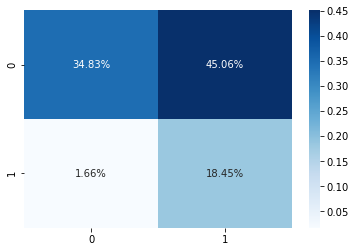

In [334]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [335]:
recall_t = []

for t in np.arange(0,1.01,0.01):
    y_pred = (grids_2['LightGBM'].predict_proba(X_test)[:,1]>t).astype(int)
    recall_t.append(recall_score(y_test,y_pred))   

In [336]:
precision_t = []

for t in np.arange(0,1.01,0.01):
    y_pred = (grids_2['LightGBM'].predict_proba(X_test)[:,1]>t).astype(int)
    precision_t.append(precision_score(y_test,y_pred))

[Text(0, 0.5, 'Valor de Metrica'), Text(0.5, 0, 'Threshold')]

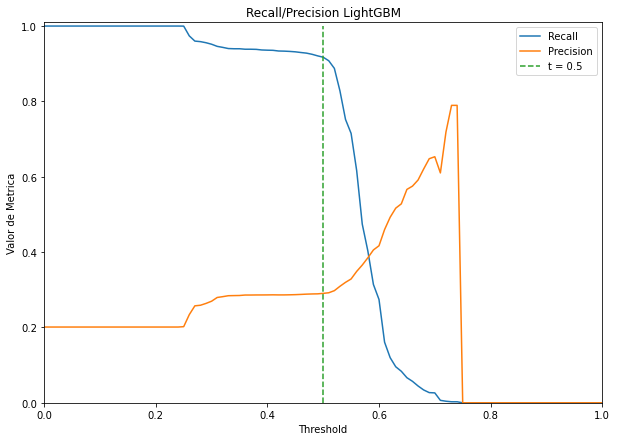

In [337]:
fig, axs = plt.subplots(1, 1, figsize=(10,7))

title = 'Recall/Precision LightGBM'
axs.set_ylim(ymin = 0, ymax =1.01)
axs.set_xlim(xmin = 0, xmax =1)
axs.set_title(title)
axs.plot(np.arange(0,1.01,0.01), recall_t, label = 'Recall')
axs.plot(np.arange(0,1.01,0.01), precision_t, label = 'Precision')
axs.plot(np.ones(101)*0.5,np.arange(0,1.01,0.01), label = 't = 0.5', linestyle = '--')
axs.legend()
axs.set(ylabel='Valor de Metrica', xlabel='Threshold')

## Seleccion del mejor Modelo

In [338]:
best_2 = grids_2['LightGBM']

### Analisis del Modelo en pacientes que fueron una unica vez

In [339]:
M = d.groupby('PatientId').aux.sum() == 1
indices_1 = M[M].index
indices_2 = M[~M].index
data_pacientes_unicos = d.set_index('PatientId').loc[indices_1,:].reset_index()
data_pacientes_no_unicos = d.set_index('PatientId').loc[indices_2,:].reset_index()


In [340]:
X_2 = data_pacientes_unicos.drop(columns = ['PatientId',
                         'No_show',
                         'Neighbourhood',
                         'ScheduledDay_time',
                         'ScheduledDay_day',
                         'ScheduledDay_month',
                         'ScheduledDay_year',
                         'AppointmentDay_time',
                         'AppointmentDay_day',
                         'AppointmentDay_month', 
                         'AppointmentDay_year',
                         'aux', 'Age'])
               
y_2 = data_pacientes_unicos.No_show

In [341]:
print(classification_report(y_2, best_2.predict(X_2)))

              precision    recall  f1-score   support

           0       0.97      0.42      0.59     30787
           1       0.28      0.95      0.43      7150

    accuracy                           0.52     37937
   macro avg       0.63      0.69      0.51     37937
weighted avg       0.84      0.52      0.56     37937



In [342]:
confusion_matrix(y_2, best_2.predict(X_2), normalize = 'true')

array([[0.42037224, 0.57962776],
       [0.04825175, 0.95174825]])

### Analisis del Modelo en pacientes que fueron mas de una vez

In [343]:
X_2 = data_pacientes_no_unicos.drop(columns = ['PatientId',
                         'No_show',
                         'Neighbourhood',
                         'ScheduledDay_time',
                         'ScheduledDay_day',
                         'ScheduledDay_month',
                         'ScheduledDay_year',
                         'AppointmentDay_time',
                         'AppointmentDay_day',
                         'AppointmentDay_month', 
                         'AppointmentDay_year',
                         'aux', 'Age'])
               
y_2 = data_pacientes_no_unicos.No_show

In [344]:
print(classification_report(y_2, best_2.predict(X_2)))

              precision    recall  f1-score   support

           0       0.95      0.44      0.60     56771
           1       0.30      0.90      0.45     14891

    accuracy                           0.54     71662
   macro avg       0.62      0.67      0.53     71662
weighted avg       0.81      0.54      0.57     71662



In [345]:
confusion_matrix(y_2, best_2.predict(X_2), normalize = 'true')

array([[0.44202145, 0.55797855],
       [0.09643409, 0.90356591]])

# Model Explain

In [346]:
shap.initjs()

In [347]:
best_2

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('balancer', RandomOverSampler()),
                                       ('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'ScheduledDay_day_of_week',
                                                                          'AppointmentDay_day_of_week',
                                                                          'App_...
             param_grid={'balancer': [RandomUnderSampler(),
                                      RandomOverSampler()],
                         'balancer__sampling_strategy': [0.6, 'auto'],
                         'clasificador__class_weight': ['balanced', None],
                         'clasificador__learning_rate': [0.1, 0.01, 1],
                         'clasificador__max_depth': [6, -1],
                         'clasificador__n_estimators': [100, 1000],
                         'clasificador__num_leaves': [30, 60]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

In [348]:
t1 = best_2.best_estimator_.named_steps['balancer']

In [349]:
t2 = best_2.best_estimator_.named_steps['preprocessor']

In [350]:
model = best_2.best_estimator_.named_steps['clasificador']

In [351]:
datos_test = pd.DataFrame(data = t2.fit_transform(X_test), columns=list(grids_2['LightGBM'].best_estimator_.named_steps['preprocessor'].transformers_[0][1].named_steps['encoder'].get_feature_names())+num_features+cat_dum_features)

# Interpretacion del modelo con LIME

In [352]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(datos_test),
    feature_names=datos_test.columns,
    class_names=[0,1],
    mode='classification'
)

In [353]:
exp = explainer.explain_instance(
    data_row=datos_test.iloc[5], 
    predict_fn=model.predict_proba
)

exp.show_in_notebook(show_table=True)

In [354]:
y_test.iloc[5]

0

## Interpretacion del modelo con  SHAP

In [355]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(datos_test)

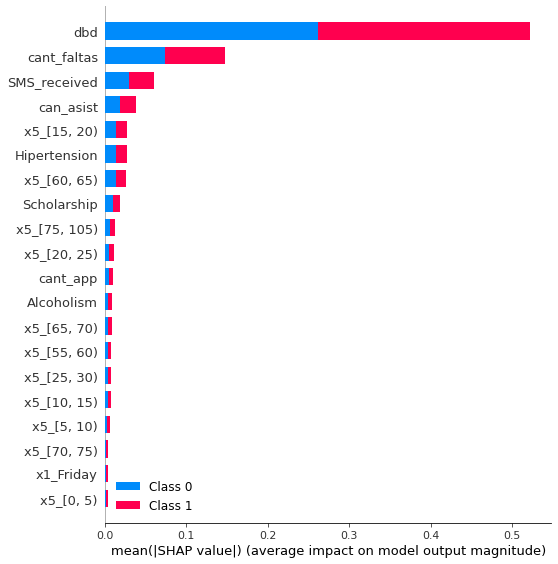

In [356]:
shap.summary_plot(shap_values, datos_test, plot_type="bar")

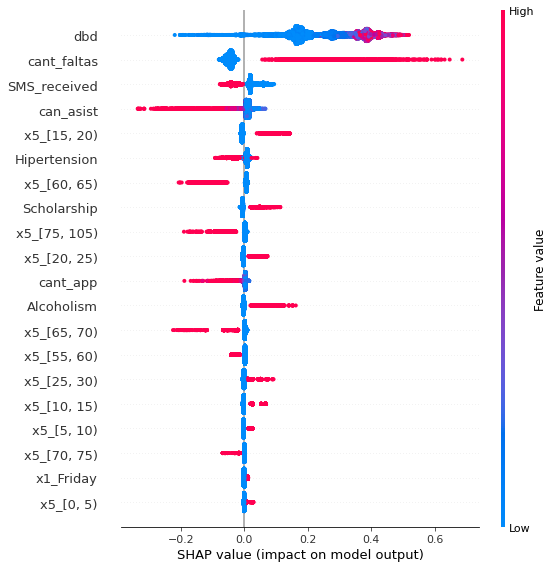

In [357]:
shap.summary_plot(shap_values[1], datos_test)

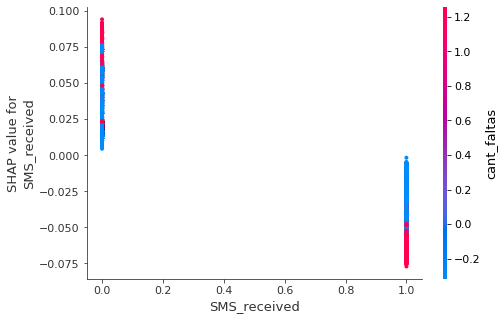

In [358]:
shap.dependence_plot('SMS_received', shap_values[1], datos_test, interaction_index = 'cant_faltas')

In [359]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], datos_test.iloc[5, :])


In [360]:
datos_test.iloc[5, :]

x0_F            1.000000
x0_M            0.000000
x1_Friday       0.000000
x1_Monday       0.000000
x1_Saturday     0.000000
x1_Thursday     0.000000
x1_Tuesday      1.000000
x1_Wednesday    0.000000
x2_Friday       0.000000
x2_Monday       0.000000
x2_Saturday     0.000000
x2_Thursday     0.000000
x2_Tuesday      1.000000
x2_Wednesday    0.000000
x3_1-10         0.000000
x3_11-20        0.000000
x3_20-31        1.000000
x4_1-10         0.000000
x4_11-20        0.000000
x4_20-31        1.000000
x5_[0, 5)       0.000000
x5_[5, 10)      0.000000
x5_[10, 15)     0.000000
x5_[15, 20)     0.000000
x5_[20, 25)     0.000000
x5_[25, 30)     1.000000
x5_[30, 35)     0.000000
x5_[35, 40)     0.000000
x5_[40, 45)     0.000000
x5_[45, 50)     0.000000
x5_[50, 55)     0.000000
x5_[55, 60)     0.000000
x5_[60, 65)     0.000000
x5_[65, 70)     0.000000
x5_[70, 75)     0.000000
x5_[75, 105)    0.000000
cant_faltas    -0.317421
cant_app        0.196408
can_asist       0.262165
dbd            -0.668895


# Conclusiones


In [380]:
from scipy.stats import ttest_1samp
import numpy as np
tset, pval = ttest_1samp(d[d.SMS_received == 0].No_show, 0.27)
print('p-values',pval)
if pval < 0.05:    # alpha value is 0.05 or 5%
   print(" we are rejecting null hypothesis")
else:
  print("we are not rejecting null hypothesis")

p-values 0.0
 we are rejecting null hypothesis


In [ ]:
El presentismo de la personas mejora luego de enviar un SMS
Se observaron ciertas inconsistencias en los datos
